In [1]:
import pandas as pd
import numpy as np
import shap
from floridaman import data_cleaning

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

In [2]:
# load in data
raw_data = data_cleaning.load('null_transformed')

In [3]:
test_columns = ['AVG_LIQUID_VOLUME', 'chemgroup1_any', 'AVG_PRESSURE_CASING', 'NIPPLE_SET_DEPTH', 'dls_high_in_hole', 'overall_max_sideload', 'YesterdaysAverageSPM', 'MAX_INCLINATION', 'pump_bore', 'AVG_PRESSURE_TUBING', 'StrokeLength', 'rod_apigrade', 'ROUTE']


full_data = data_cleaning.drop_columns(raw_data, .4, .4)
balanced_data = data_cleaning.balance(full_data)

full_data = data_cleaning.impute_values(full_data, 5)
balanced_data = data_cleaning.impute_values(balanced_data, 5)

y_train = np.array(balanced_data['FAILURETYPE'])
y_test = np.array(full_data['FAILURETYPE'])

#removing columns not relevant to model
for col in full_data:
    if not(col in test_columns):
        full_data = full_data.drop(col, axis=1)
        
#removing columns not relevant to model
for col in balanced_data:
    if not(col in test_columns):
        balanced_data = balanced_data.drop(col, axis=1)


X_train = np.array(balanced_data)

X_test = np.array(full_data)


### Optimize Random Forest through Random Search

In [4]:
# Specify hyperparameters
n_estimators = [int(x) for x in np.linspace(start = 4, stop = 10, num = 10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

In [5]:
# Create the hyperparameter grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [6]:
# Create a basic RF classifier
rf_model = RandomForestClassifier()

# Create grid search object with specified parameter grid. Perform 
# cross validation with 8 folds to randomly select combinations of hyperparameters 
# from random_grid and return the combination that performs the best.
rf_grid = GridSearchCV(estimator = rf_model, param_grid = random_grid, cv = 8, verbose = 2, n_jobs = -1)
# LOL n_jobs = 12 for the 14 core machine - please change this to something reasonable like 4

# Fit classifier to X_train and y_train
rf_grid.fit(X_train, y_train)

Fitting 8 folds for each of 4320 candidates, totalling 34560 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 408 tasks      | elapsed:    6.8s
[Parallel(n_jobs=-1)]: Done 1220 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 2352 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 3812 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 5592 tasks      | elapsed:   43.0s
[Parallel(n_jobs=-1)]: Done 7700 tasks      | elapsed:   56.9s
[Parallel(n_jobs=-1)]: Done 10128 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 12884 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 15960 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 19364 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 23088 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 27140 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 31512 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 34560 out

GridSearchCV(cv=8, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,...
                                              random_state=None, verbose=0,
                                   

In [7]:
# Create better model with tuned hyperparameters
best_model = rf_grid.best_estimator_

### Random Forest Results

In [8]:
print(str(classification_report(y_test, best_model.predict(X_test))))
print("")
print("Classifier training score: " + str(best_model.score(X_train, y_train)))
print("Best combination of hyperparameters: ")
rf_grid.best_params_ # prints the best combination of hyperparameters for our data set 

                 precision    recall  f1-score   support

           Rods       0.26      0.71      0.38       207
Sucker Rod Pump       0.64      0.53      0.58       590
         Tubing       0.73      0.52      0.61       874

       accuracy                           0.55      1671
      macro avg       0.54      0.59      0.52      1671
   weighted avg       0.64      0.55      0.57      1671


Classifier training score: 0.8115942028985508
Best combination of hyperparameters: 


{'bootstrap': True,
 'max_depth': 70,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 8}

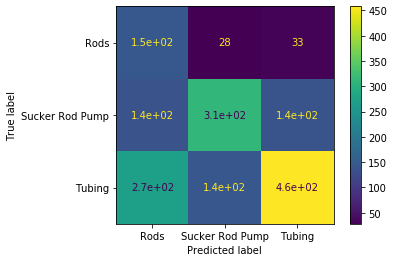

In [9]:
# Plot the confusion matrix
cm = plot_confusion_matrix(best_model, X_test, y_test)

# SHAP 

In [10]:
import matplotlib.pyplot as plt
explainer = shap.TreeExplainer(best_model)
shap_values = explainer.shap_values(X_test)
shap.initjs()

#### class # as we encoded it:
- Rods = 0
- SRP = 1
- Tubing = 2

### Summary for all features and all classes (including Noise)

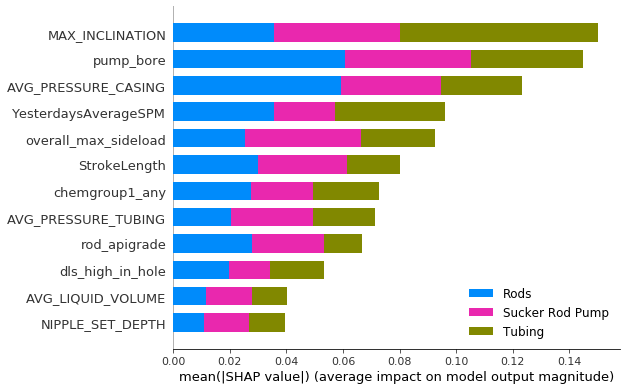

In [11]:
shap.summary_plot(shap_values, 
                  X_test, 
                  max_display = 15,
                  feature_names = data_cleaning.features(test_columns), 
                  class_names = ['Rods', 'Sucker Rod Pump', 'Tubing'], 
                  show=False)
#plt.savefig('summaryPlot.png')

In [24]:
#shap.save_html('RandomShapSRP.html',
shap.force_plot(explainer.expected_value[1], 
                shap_values[1], 
                X_test, 
                feature_names = data_cleaning.features(balanced_data),
                matplotlib=False)

In [30]:
#shap.save_html('RandomShapRods.html',
shap.force_plot(explainer.expected_value[0], 
                               shap_values[0], X_test, 
                               feature_names = data_cleaning.features(balanced_data),
                               matplotlib=False)

In [28]:
#shap.save_html('RandomShapTubing.html',
shap.force_plot(explainer.expected_value[2], 
                               shap_values[2], X_test, 
                               feature_names = data_cleaning.features(balanced_data),
                               matplotlib=False)#)